# Itération 1

## Intitulé de l'itération

### age	height	weight	duration	heart_rate	body_temp

### Label enconder

### Régression linéaire

### Plot des prédiction par rapport au train sur toutes les features

### Learning curve

## Import

In [1]:
import os
import psycopg2
from dotenv import load_dotenv

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge


# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('seaborn')

# Affichage cellule
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_row', 1000)
from pprint import pprint

# Chargement du model pour déploiement
import pickle

## Connection à la DB sécurisé via des variables d'environnement

### création de la chaine de connexion

In [2]:


load_dotenv()  # Nécessaire pour charger les variables d'environnement précédemment définies

# Créer une connexion à postgres
connection = psycopg2.connect(host=os.environ.get('PG_HOST'),
                        user=os.environ.get('PG_USER'),
                        password=os.environ.get('PG_PASSWORD'),
                        dbname=os.environ.get('PG_DATABASE'))

connection.autocommit = True  # Assurez-vous que les données sont ajoutées à la base de données immédiatement après les commandes d'écriture.
cursor = connection.cursor()
cursor.execute('SELECT %s as connected;', ('Connection à postgres Réussie!',))
print(cursor.fetchone())

('Connection à postgres Réussie!',)


### Fonction de création du dataframe

In [3]:
def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Transformer une requête SELECT en un dataframe pandas
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturellement, nous obtenons une liste de "tupples".
    tupples = cursor.fetchall()
    cursor.close()
    
    # Nous devons juste le transformer en dataframe pandas.
    df = pd.DataFrame(tupples, columns=column_names)
    return df

### Récupération de postgresql au dataframe

In [4]:
conn = connection
column_names = ["user_id","gender", "age", "height", "weight", "duration", "heart_rate", "body_temp", "calorie"]
# Execute the "SELECT *" query
df_db = postgresql_to_dataframe(conn, 
"SELECT persons.user_id as id, gender, age, height, weight, duration, heart_rate, body_temp,calorie FROM calories INNER JOIN persons ON calories.user_id = persons.user_id"
                                , column_names)
df_db.head()

,user_id,gender,age,height,weight,duration,heart_rate,body_temp,calorie
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


##  Exploration

### Checker les infos de base de mon dataframe

In [5]:
df_db.shape

(15000, 9)

In [6]:
# Explorer les types, les valeurs nulles, les catégorie des variables, le nombre de colonnes
df_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_id     15000 non-null  int64  
 1   gender      15000 non-null  object 
 2   age         15000 non-null  int64  
 3   height      15000 non-null  float64
 4   weight      15000 non-null  float64
 5   duration    15000 non-null  float64
 6   heart_rate  15000 non-null  float64
 7   body_temp   15000 non-null  float64
 8   calorie     15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


### Visualisation des varaiables en histogrammes

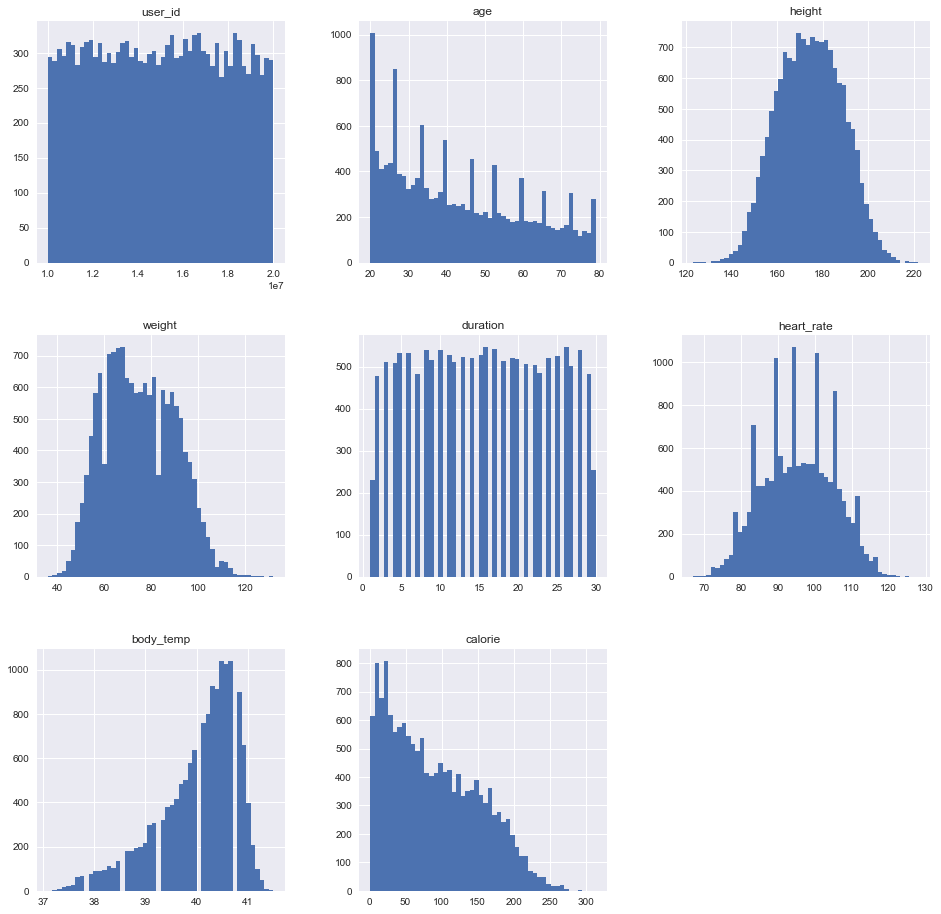

In [5]:
# His
df_db.hist(bins=50,figsize=(16,16))
plt.show()

### matrice de corrélation

In [5]:
cor_df = df_db.corr() 
cor_df['calorie'].sort_values(ascending= False)

calorie       1.000000
duration      0.955421
heart_rate    0.897882
body_temp     0.824558
age           0.154395
weight        0.035481
height        0.017537
user_id      -0.001661
Name: calorie, dtype: float64

## Modele

In [5]:
# # utilisation des doubles crochets pour renvoyer un DataFrame pour la variable  X
X = df_db[['duration']]
# y unidimensionnel
y = df_db['calorie']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=10)

In [7]:
X.head(1)

,duration
0,29.0


### Régression linéaire simple

In [7]:
model_lineaire = LinearRegression()
model_lineaire.fit(X_train,y_train)

LinearRegression()

#### Score 

In [8]:
model_lineaire.score(X_test,y_test)

0.9132237752267383

In [9]:
# je fais ma prediction sur mon jeu de test
yPrediction = model_lineaire.predict(X_test)
# notre model décrit 91% des variations du calories brulées par rapport a la duréee d'exercice

In [12]:
train_sizes, train_scores, test_scores = learning_curve(model_lineaire, X, y, cv=10, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

#### Graphique représentant la prédiction des calories a partir du jeu d'entrainement

In [13]:
# Nous allons maintenant calculé la moyenne et l'écart-type des scores d'entraînement et de test.
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

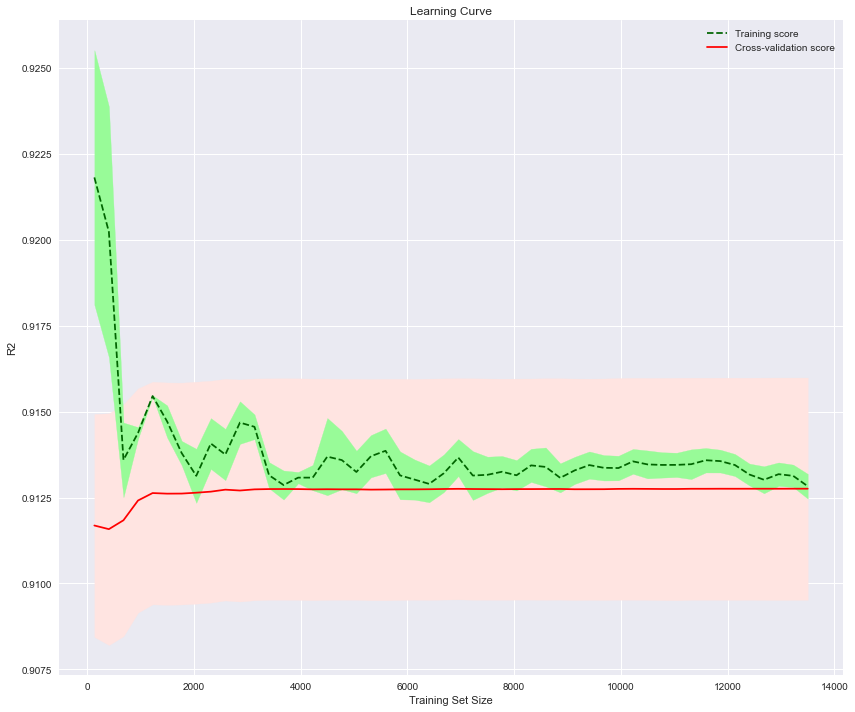

In [14]:
plt.subplots(1, figsize=(12,10))
plt.plot(train_sizes, train_mean, '--', color="darkgreen",  label="Training score")
plt.plot(train_sizes, test_mean, color="red", label="Cross-validation score")

plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="mistyrose")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="palegreen")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("R2"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [10]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error

# a savoir la MSE pénalise bcp plus les grandes erreurs que la MAE
# MAE l'importanced'une erreur est linéaire avec son amplitude. si le dataset contient des **valeurs aberrantes**
print('MAE : ',mean_absolute_error(y_test, yPrediction))

# MSE si on accorde une grande importance aux garndes erreurs
print('RMSE : ',mean_squared_error(y_test, yPrediction))

print('Le coefficient de détermination ou R2 : ',r2_score(y_test, yPrediction))

# moins sensible au valeurs aberrantes
print('Mediane AE : Le model fais une erreur de prediction en moyenne de ',median_absolute_error(y_test, yPrediction), 'calories brulées ce qui est trés bien')

MAE :  13.522473647813023
RMSE :  338.1700371364356
Le coefficient de détermination ou R2 :  0.9132237752267383
Mediane AE : Le model fais une erreur de prediction en moyenne de  10.384579260526337 calories brulées ce qui est trés bien


In [11]:
# erreur absolu dans une variable pour l'afficher en histogramme
histogramme_erreur = np.abs(y_test, yPrediction)

Text(0, 0.5, 'Nombre de prediction')

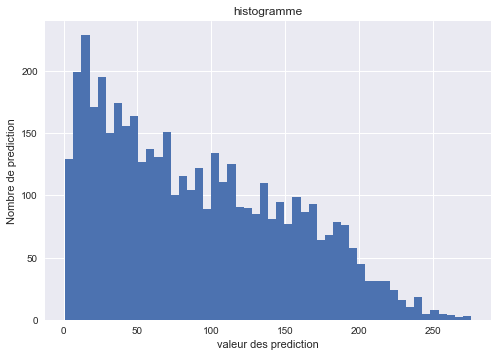

In [12]:
# bins : représente les intervalles
plt.hist(histogramme_erreur, bins=50)
plt.title('histogramme')
plt.xlabel('valeur des prediction')
plt.ylabel('Nombre de prediction')

# je vois que sur toutes les prédictions faites 200 ont une erreur proche de zero
# je vois que mes erreur suivent une loi de distribution expodentiel

# Itération 2

## Comparatif de plusieurs modèles avec une caractéristique

In [13]:
pipelines = list()
pipelines.append(('LinearRegression', Pipeline([('LR', LinearRegression())])))
pipelines.append(('Lasso', Pipeline([('LS', linear_model.Lasso(alpha=0.3))])))
pipelines.append(('Ridge', Pipeline([('RDG', linear_model.Ridge(alpha=10))])))
#pipelines.append(('RidgeCV', Pipeline([('RDG_CV', linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13)))])))

pipelines.append(('PolynomialLinearRegression', Pipeline([('PLR', PolynomialFeatures(degree=2)), ('linear', linear_model.LinearRegression(fit_intercept=False))])))
pipelines.append(('RandomForestRegressor', Pipeline([('RF', RandomForestRegressor(n_estimators=10, n_jobs=6, max_depth=20))])))
  
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=5)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f" % (name, cv_results.mean())
    print(msg)

LinearRegression: 0.912601
Lasso: 0.912600
Ridge: 0.912601
PolynomialLinearRegression: 0.928792
RandomForestRegressor: 0.928482


## Pickle

### Créer un objet itérateur avec droit d'écriture - model.pkl

In [14]:
#with open('model/duration_LR_pkl', 'wb') as files:
#    pickle.dump(LinearRegression, files)

FileNotFoundError: [Errno 2] No such file or directory: 'model/duration_LR_pkl'

In [8]:
#pipelines

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

In [17]:
with open('model_lineaire_pkl', 'wb') as files:
    pickle.dump(model_lineaire, files)
    
#with open('model/duration_RandomForestRegressor_pkl', 'wb') as files:
#    pickle.dump(RandomForestRegressor, files)